# **Importer les Bibliothèques et Initialiser Spark**

In [96]:
import sys
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, BooleanType

In [97]:
spark = SparkSession.builder \
    .appName("Data Processing dans catalogue csv") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()
print("Session Spark initialisée avec succès.")


Session Spark initialisée avec succès.


# **Charger et normaliser  les données depuis le fichier Hive**


In [98]:
# Charger les données depuis Hive
spark.sql("USE concessionnaire")
catalogue_df = spark.sql("SELECT * FROM catalogue_table_processed")

co2_df = spark.sql("SELECT * FROM co2_data_processed")


# Normaliser les colonnes de marque
co2_df = co2_df.withColumn("marque", F.lower(F.trim(F.col("marque"))))
catalogue_df = catalogue_df.withColumn("marque", F.lower(F.trim(F.col("marque"))))

co2_df = co2_df.withColumn("modele", F.lower(F.trim(F.col("modele"))))
catalogue_df = catalogue_df.withColumn("modele", F.lower(F.trim(F.col("modele"))))
# Vérifier les données chargées
print("Données Catalogue :")
catalogue_df.show(5)

print("Données CO2 :")
co2_df.show(1000)

Données Catalogue :
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+
|    marque|    modele|modele_detail|unified_horse_power|   longueur|nbplaces|nbportes|couleur|occasion|    prix|
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+
|   renault|    espace|         2.0T|                165|     longue|       7|       5|  rouge|    true| 21245.0|
|volkswagen|new beatle|          1.8|                110|    moyenne|       5|       5|   gris|   false| 26630.0|
|       bmw|        m5|             |                507|très longue|       5|       5|   bleu|    true| 66360.0|
|    nissan|    maxima|       3.0 V6|                200|très longue|       5|       5|  rouge|   false| 30000.0|
|  mercedes|      s500|             |                306|très longue|       5|       5|   noir|   false|101300.0|
+----------+----------+-------------+-------------------+-----------

# **Creation de **final_catalogue_df**  qui servira lors de la fusion des data  **

In [99]:
# Définir le schéma du DataFrame vide avec les bonnes colonnes
schema = StructType([
    StructField("marque", StringType(), True),
    StructField("modele", StringType(), True),
    StructField("modele_detail", StringType(), True),
    StructField("unified_horse_power", FloatType(), True),
    StructField("longueur", FloatType(), True),
    StructField("nbplaces", IntegerType(), True),
    StructField("nbportes", IntegerType(), True),
    StructField("couleur", StringType(), True),
    StructField("occasion", BooleanType(), True),
    StructField("prix", FloatType(), True),
    StructField("bonus_malus", FloatType(), True),
    StructField("cout_energie", FloatType(), True),
    StructField("rejets_co2", FloatType(), True)
])

# Créer le DataFrame vide avec ce schéma
final_catalogue_df = spark.createDataFrame([], schema)

# Afficher le DataFrame vide
final_catalogue_df.show(truncate=False)


+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+------------+----------+
|marque|modele|modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix|bonus_malus|cout_energie|rejets_co2|
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+------------+----------+
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+------------+----------+


# **Drop duplicate sur co2 et catalogue**

In [100]:
# Liste des colonnes à utiliser pour vérifier l'unicité (toutes sauf 'couleur')
columns_to_check = [col for col in catalogue_df.columns if col != "couleur"]
print(f"Nombre de lignes uniques dans Catalogue avant suppression des doublons (sans 'couleur') : {catalogue_df.count()}")

# Supprimer doublons dans le fichier CO2 au cas ou
co2_df = co2_df.dropDuplicates()

# Supprimer les doublons en se basant sur toutes les colonnes sauf 'couleur'
catalogue_df = catalogue_df.dropDuplicates()

# Vérifier les résultats après suppression des doublons
print(f"Nombre de lignes uniques dans Co2 après suppression des doublons : {co2_df.count()}")
print(f"Nombre de lignes uniques dans Catalogue après suppression des doublons (sans 'couleur') : {catalogue_df.count()}")
catalogue_df.show(truncate=False)


Nombre de lignes uniques dans Catalogue avant suppression des doublons (sans 'couleur') : 2430
Nombre de lignes uniques dans Co2 après suppression des doublons : 175
Nombre de lignes uniques dans Catalogue après suppression des doublons (sans 'couleur') : 270
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+-------+
|marque    |modele    |modele_detail|unified_horse_power|longueur   |nbplaces|nbportes|couleur|occasion|prix   |
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+-------+
|lancia    |ypsilon   |1.4 16V      |90                 |courte     |5       |3       |noir   |false   |13500.0|
|saab      |9.3       |1.8T         |150                |longue     |5       |5       |noir   |false   |38600.0|
|mercedes  |a200      |             |136                |moyenne    |5       |5       |blanc  |true    |18130.0|
|ford      |mondeo    |1.8          |125                |longu

# **Fusionner les Données dans final_catalogue_df**

In [101]:
#fusionner les données
final_catalogue_df = final_catalogue_df.unionByName(catalogue_df, allowMissingColumns=True)

print(f"Nombre de lignes dans le catalogue final fusionné : {final_catalogue_df.count()}")
final_catalogue_df.show()

Nombre de lignes dans le catalogue final fusionné : 270
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+-------+-----------+------------+----------+
|    marque|    modele|modele_detail|unified_horse_power|   longueur|nbplaces|nbportes|couleur|occasion|   prix|bonus_malus|cout_energie|rejets_co2|
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+-------+-----------+------------+----------+
|    lancia|   ypsilon|      1.4 16V|               90.0|     courte|       5|       3|   noir|   false|13500.0|       NULL|        NULL|      NULL|
|      saab|       9.3|         1.8T|              150.0|     longue|       5|       5|   noir|   false|38600.0|       NULL|        NULL|      NULL|
|  mercedes|      a200|             |              136.0|    moyenne|       5|       5|  blanc|    true|18130.0|       NULL|        NULL|      NULL|
|      ford|    mondeo|          1.8|             

# **Modèles du catalogue absent de co2 et ajout des m**

In [102]:
from pyspark.sql import functions as F

# Étape 1 : Calculez les moyennes par marque dans co2_df
averages_by_marque = co2_df.groupBy("marque").agg(
    F.round(F.avg("bonus_malus"), 1).alias("avg_bonus_malus_by_marque"),
    F.round(F.avg("rejets_co2"), 1).alias("avg_rejets_co2_by_marque"),
    F.round(F.avg("cout_energie"), 1).alias("avg_cout_energie_by_marque")
)

# Étape 2 : Joignez final_catalogue_df avec co2_df pour obtenir les valeurs existantes
co2_df_select = co2_df.select(
    "marque",
    "modele",
    F.col("bonus_malus").alias("co2_bonus_malus"),
    F.col("rejets_co2").alias("co2_rejets_co2"),
    F.col("cout_energie").alias("co2_cout_energie")
)

final_with_co2 = final_catalogue_df.join(
    co2_df_select,
    on=["marque", "modele"],
    how="left"
)

# Étape 3 : Joignez avec les moyennes par marque
final_with_co2_and_averages = final_with_co2.join(
    averages_by_marque,
    on="marque",
    how="left"
)

# Étape 4 : Remplacez les valeurs manquantes par les valeurs correspondantes ou les moyennes
final_catalogue_df_enriched = final_with_co2_and_averages.withColumn(
    "bonus_malus",
    F.coalesce(
        final_with_co2_and_averages["bonus_malus"],  # Valeur originale
        final_with_co2_and_averages["co2_bonus_malus"],  # Valeur de co2_df
        final_with_co2_and_averages["avg_bonus_malus_by_marque"]  # Moyenne par marque
    )
).withColumn(
    "rejets_co2",
    F.coalesce(
        final_with_co2_and_averages["rejets_co2"],
        final_with_co2_and_averages["co2_rejets_co2"],
        final_with_co2_and_averages["avg_rejets_co2_by_marque"]
    )
).withColumn(
    "cout_energie",
    F.coalesce(
        final_with_co2_and_averages["cout_energie"],
        final_with_co2_and_averages["co2_cout_energie"],
        final_with_co2_and_averages["avg_cout_energie_by_marque"]
    )
)

# Étape 5 : Sélectionnez les colonnes finales
final_catalogue_df_enriched = final_catalogue_df_enriched.select(
    "marque", "modele", "modele_detail", "unified_horse_power",
    "longueur", "nbplaces", "nbportes", "couleur", "occasion", "prix",
    "bonus_malus", "rejets_co2", "cout_energie"
)

# Étape 6 : Affichez les résultats finaux
print("Catalogue final enrichi avec les moyennes de CO2 pour les modèles absents :")
final_catalogue_df_enriched.show(1000, truncate=False)

# Nombre de lignes dans le catalogue final
print(f"Nombre total de lignes dans le catalogue final enrichi : {final_catalogue_df_enriched.count()}")


Catalogue final enrichi avec les moyennes de CO2 pour les modèles absents :
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+-----------+----------+------------+
|marque    |modele    |modele_detail|unified_horse_power|longueur   |nbplaces|nbportes|couleur|occasion|prix    |bonus_malus|rejets_co2|cout_energie|
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+-----------+----------+------------+
|renault   |laguna    |2.0T         |170.0              |longue     |5       |5       |gris   |true    |19110.0 |-6000.0    |0.0       |206.0       |
|daihatsu  |cuore     |1.0          |58.0               |courte     |5       |3       |rouge  |false   |8850.0  |NULL       |NULL      |NULL        |
|peugeot   |1007      |1.4          |75.0               |courte     |5       |5       |bleu   |true    |9625.0  |-6000.0    |12.8      |159.6       |
|kia       |picanto   |1

# **Recalculcul des moyenne dasn final_df  et co2**


In [103]:
# Enregistrer final_catalogue_df comme vue temporaire
final_catalogue_df.createOrReplaceTempView("final_catalogue_temp_view")
co2_df.createOrReplaceTempView("co2_temp_view")


# Combiner les deux sources et calculer les moyennes
combined_averages_sql = spark.sql("""
    SELECT 
        ROUND(AVG(bonus_malus), 1) AS avg_bonus_malus,
        ROUND(AVG(rejets_co2), 1) AS avg_rejets_co2,
        ROUND(AVG(cout_energie), 1) AS avg_cout_energie
    FROM (
        SELECT bonus_malus, rejets_co2, cout_energie 
        FROM final_catalogue_temp_view
        WHERE bonus_malus IS NOT NULL AND rejets_co2 IS NOT NULL AND cout_energie IS NOT NULL
        UNION ALL
        SELECT bonus_malus, rejets_co2, cout_energie 
        FROM co2_temp_view
        WHERE bonus_malus IS NOT NULL AND rejets_co2 IS NOT NULL AND cout_energie IS NOT NULL
    ) combined_data
""")
combined_averages = combined_averages_sql.collect()[0]
print("Moyennes combinées (final_catalogue_df et co2_df) :", combined_averages)

print({
    "avg_bonus_malus": combined_averages["avg_bonus_malus"],
    "avg_rejets_co2": combined_averages["avg_rejets_co2"],
    "avg_cout_energie": combined_averages["avg_cout_energie"]
})

# Extraire les moyennes
avg_bonus_malus = combined_averages["avg_bonus_malus"]
avg_rejets_co2 = combined_averages["avg_rejets_co2"]
avg_cout_energie = combined_averages["avg_cout_energie"]
#drop temp view
spark.catalog.dropTempView("final_catalogue_temp_view")
spark.catalog.dropTempView("co2_temp_view")




Moyennes combinées (final_catalogue_df et co2_df) : Row(avg_bonus_malus=2554.7, avg_rejets_co2=121.5, avg_cout_energie=586.2)
{'avg_bonus_malus': 2554.7, 'avg_rejets_co2': 121.5, 'avg_cout_energie': 586.2}


True

# **Marques Absentes dans CO2**

In [104]:
from pyspark.sql import functions as F
print("Catalogue final enrichi avec les moyennes de CO2 pour les modèles absents :")
final_catalogue_df_enriched.show(1000, truncate=False)
# Étape 1 : Calculer les moyennes combinées (déjà fait)

# Étape 2 : Identifier les marques absentes dans co2_df (déjà fait)
# Obtenir la liste des marques absentes dans co2_df
marques_absentes_df = final_catalogue_df_enriched.select("marque").distinct().join(
    co2_df.select("marque").distinct(),
    on="marque",
    how="left_anti"
)
marques_absentes = [row["marque"] for row in marques_absentes_df.collect()]

print(f"Marques absentes dans CO2 : {len(marques_absentes)}")
print(marques_absentes)

# Étape 3 : Identifier les enregistrements à mettre à jour
unique_cols = ["marque", "modele", "modele_detail"]

models_to_update = final_catalogue_df_enriched.filter(
    (F.col("marque").isin(marques_absentes)) &
    (F.col("bonus_malus").isNull()) &
    (F.col("rejets_co2").isNull()) &
    (F.col("cout_energie").isNull())
)

# Étape 4 : Enrichir ces enregistrements avec les moyennes combinées
models_with_combined_averages = models_to_update.withColumn(
    "bonus_malus", F.lit(avg_bonus_malus)
).withColumn(
    "rejets_co2", F.lit(avg_rejets_co2)
).withColumn(
    "cout_energie", F.lit(avg_cout_energie)
)

# Étape 5 : Fusionner les enregistrements enrichis avec le reste du catalogue
keys_to_update = models_to_update.select(unique_cols).distinct()

final_catalogue_df_remaining = final_catalogue_df_enriched.join(
    keys_to_update,
    on=unique_cols,
    how='left_anti'
)

final_catalogue_df_updated = final_catalogue_df_remaining.unionByName(
    models_with_combined_averages,
    allowMissingColumns=True
)

# Étape 6 : Vérifier les résultats
print("Catalogue final après enrichissement des marques absentes avec les moyennes combinées :")
final_catalogue_df_updated.show(1000, truncate=False)

# Vérifier le nombre de valeurs NULL restantes
null_counts = final_catalogue_df_updated.select([
    F.count(F.when(F.col("bonus_malus").isNull(), True)).alias("bonus_malus_nulls"),
    F.count(F.when(F.col("rejets_co2").isNull(), True)).alias("rejets_co2_nulls"),
    F.count(F.when(F.col("cout_energie").isNull(), True)).alias("cout_energie_nulls")
])
null_counts.show()


Catalogue final enrichi avec les moyennes de CO2 pour les modèles absents :
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+-----------+----------+------------+
|marque    |modele    |modele_detail|unified_horse_power|longueur   |nbplaces|nbportes|couleur|occasion|prix    |bonus_malus|rejets_co2|cout_energie|
+----------+----------+-------------+-------------------+-----------+--------+--------+-------+--------+--------+-----------+----------+------------+
|renault   |laguna    |2.0T         |170.0              |longue     |5       |5       |gris   |true    |19110.0 |-6000.0    |0.0       |206.0       |
|daihatsu  |cuore     |1.0          |58.0               |courte     |5       |3       |rouge  |false   |8850.0  |NULL       |NULL      |NULL        |
|peugeot   |1007      |1.4          |75.0               |courte     |5       |5       |bleu   |true    |9625.0  |-6000.0    |12.8      |159.6       |
|kia       |picanto   |1

# ***Vérifier les Données Fusionnées***

# **Données manquantes**

In [105]:
print("Nombre de valeurs NULL par colonne :")
final_catalogue_df_updated.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in final_catalogue_df_updated.columns]).show()
from pyspark.sql.functions import col, sum, when
null_counts = final_catalogue_df_updated.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in final_catalogue_df_updated.columns])
null_counts.show()
# Filtrer les enregistrements où 'bonus_malus' est NULL
null_bonus_malus_rows = final_catalogue_df_updated.filter(F.col('bonus_malus').isNull())

# Afficher ces enregistrements
print("Enregistrements avec 'bonus_malus' NULL :")
null_bonus_malus_rows.show(truncate=False)

Nombre de valeurs NULL par colonne :
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+----------+------------+
|marque|modele|modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix|bonus_malus|rejets_co2|cout_energie|
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+----------+------------+
|     0|     0|            0|                  0|       0|       0|       0|      0|       0|   0|         10|         0|           0|
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+----------+------------+
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+----------+------------+
|marque|modele|modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix|bonus_malus|rejets_co2|cout_energie|
+------+------+---

In [106]:
# Définir une plage de regroupement ( par tranches de 5 unités)
tolerance = 5

# Créer une nouvelle colonne pour grouper 'rejets_co2' par plages
final_catalogue_df_updated = final_catalogue_df_updated.withColumn(
    'rejets_co2_group',
    (F.col('rejets_co2') / tolerance).cast('int') * tolerance
)

# Calculer la moyenne de 'bonus_malus' pour chaque groupe
avg_bonus_malus_df = final_catalogue_df_updated.filter(
    F.col('bonus_malus').isNotNull()
).groupBy(
    'rejets_co2_group'
).agg(
    F.avg('bonus_malus').alias('avg_bonus_malus')
)

# Joindre les moyennes calculées au DataFrame original
final_df = final_catalogue_df_updated.join(
    avg_bonus_malus_df,
    on='rejets_co2_group',
    how='left'
)

# Remplacer les valeurs NULL de 'bonus_malus' par la moyenne du groupe
final_df = final_df.withColumn(
    'bonus_malus',
    F.when(
        F.col('bonus_malus').isNull(),
        F.col('avg_bonus_malus')
    ).otherwise(F.col('bonus_malus'))
)

# Supprimer les colonnes temporaires
final_df = final_df.drop('rejets_co2_group', 'avg_bonus_malus')

# Vérifier que les valeurs NULL ont été remplies
null_counts = final_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in final_df.columns
])
null_counts.show()


+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+----------+------------+
|marque|modele|modele_detail|unified_horse_power|longueur|nbplaces|nbportes|couleur|occasion|prix|bonus_malus|rejets_co2|cout_energie|
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+----------+------------+
|     0|     0|            0|                  0|       0|       0|       0|      0|       0|   0|          0|         0|           0|
+------+------+-------------+-------------------+--------+--------+--------+-------+--------+----+-----------+----------+------------+


# **Distribution des Prix des Véhicules**

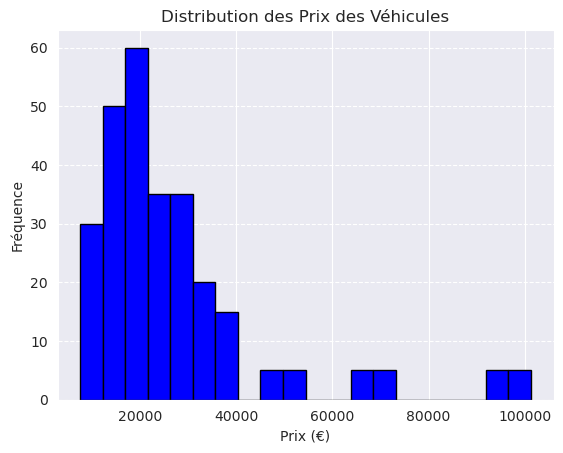

In [107]:
prices = final_catalogue_df_updated.select("prix").rdd.flatMap(lambda x: x).collect()
plt.hist(prices, bins=20, color='blue', edgecolor='black')
plt.xlabel("Prix (€)")
plt.ylabel("Fréquence")
plt.title("Distribution des Prix des Véhicules")
plt.grid(axis='y', linestyle='--')
plt.show()


La majorité des véhicules ont un prix situé entre 20 000 € et 40 000 €, avec un pic autour de 25 000 €. Les véhicules de plus de 60 000 € sont peu nombreux, ce qui montre une distribution asymétrique centrée sur des véhicules de milieu de gamme.

# **Distribution de la Puissance des Véhicules**

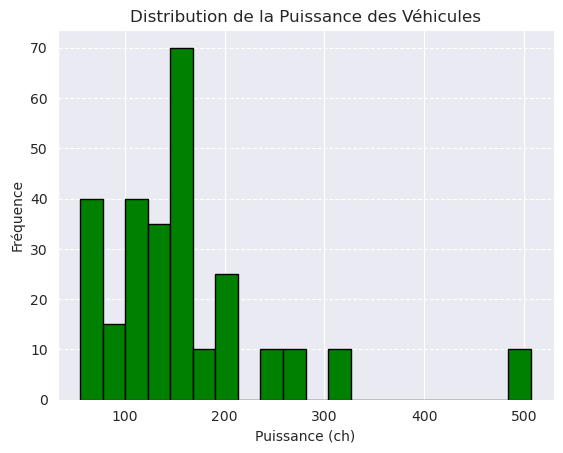

In [108]:
horsepower_data = final_catalogue_df_updated.select("unified_horse_power").rdd.flatMap(lambda x: x).collect()
plt.hist(horsepower_data, bins=20, color='green', edgecolor='black')
plt.xlabel("Puissance (ch)")
plt.ylabel("Fréquence")
plt.title("Distribution de la Puissance des Véhicules")
plt.grid(axis='y', linestyle='--')
plt.show()


La majorité des véhicules ont une puissance comprise entre 100 ch et 200 ch, avec un pic autour de 150 ch. Les véhicules de plus de 300 ch sont rares, ce qui indique une concentration sur des voitures de puissance moyenne.

# **Répartition des Marques**

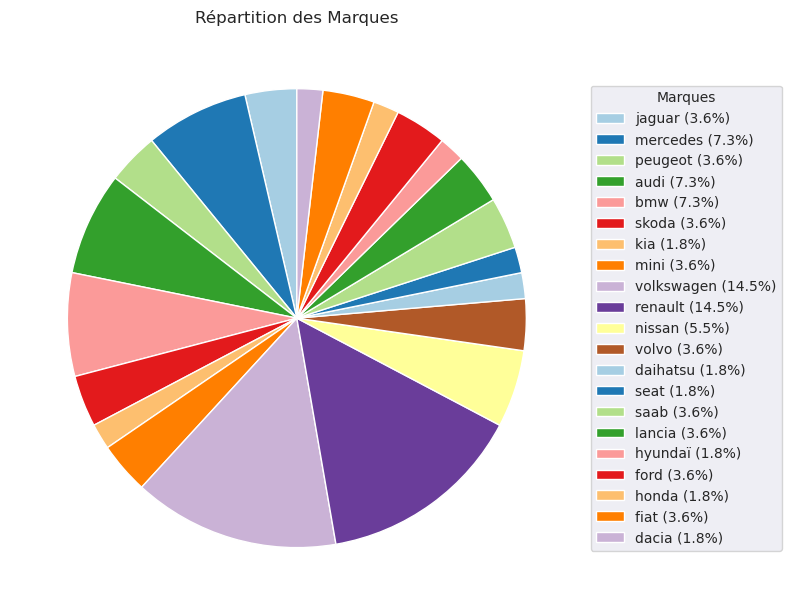

In [109]:
brand_distribution = final_catalogue_df_updated.groupBy("marque").count().toPandas()
brand_distribution["percentage"] = (brand_distribution["count"] / brand_distribution["count"].sum()) * 100

plt.figure(figsize=(8, 8))
plt.pie(brand_distribution["count"], startangle=90, colors=plt.cm.Paired.colors)
labels = [f"{row['marque']} ({row['percentage']:.1f}%)" for _, row in brand_distribution.iterrows()]
plt.legend(labels, title="Marques", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title("Répartition des Marques")
plt.tight_layout()
plt.show()

# **Matrice de Corrélation**

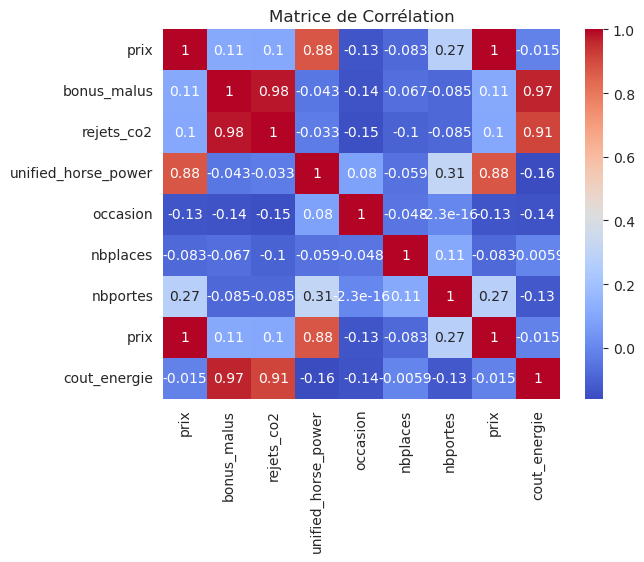

In [110]:
correlations = final_catalogue_df_updated.select("prix", "bonus_malus", "rejets_co2", "unified_horse_power","occasion","nbplaces","nbportes","prix","cout_energie").toPandas().corr()
sns.heatmap(correlations, annot=True, cmap="coolwarm")
plt.title("Matrice de Corrélation")
plt.show()

Le prix est fortement corrélé à la puissance unifiée des véhicules (0.87), ce qui est attendu pour des voitures plus puissantes.
Les rejets de CO₂ sont très fortement corrélés au bonus/malus (0.94), reflétant leur impact direct sur la taxe écologique.
La puissance unifiée a une très faible corrélation négative avec les rejets de CO₂ (-0.09), probablement dû à la présence de véhicules électriques ou hybrides puissants mais peu polluants.

# **Relation entre Puissance et Prix**

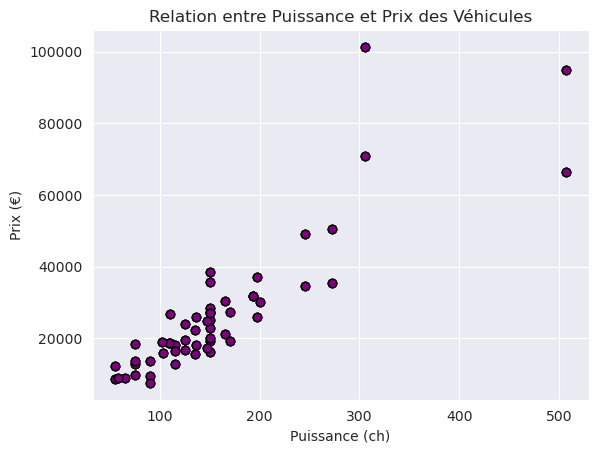

In [111]:
price_hp_data = final_catalogue_df_updated.select("prix", "unified_horse_power").rdd.map(tuple).collect()
prices, hp = zip(*price_hp_data)
plt.scatter(hp, prices, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel("Puissance (ch)")
plt.ylabel("Prix (€)")
plt.title("Relation entre Puissance et Prix des Véhicules")
plt.grid(True)
plt.show()

Le prix des véhicules augmente généralement avec la puissance, avec une tendance claire pour les puissances jusqu'à 200 ch. Cependant, au-delà de 300 ch, les prix varient fortement, reflétant la diversité des segments de véhicules, notamment les modèles haut de gamme

# **Relation entre Rejets CO2 et Bonus/Malus**

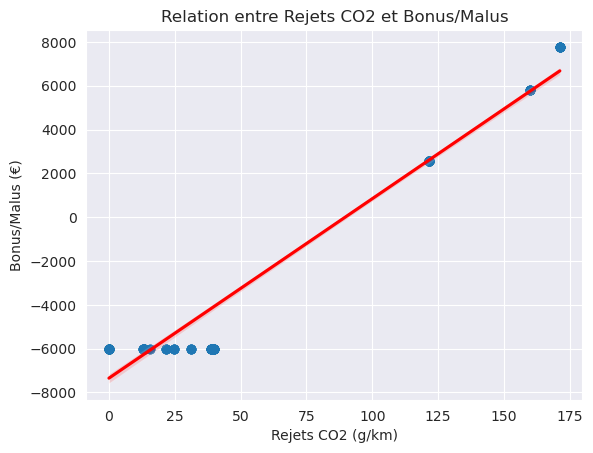

In [112]:
df_pandas = final_catalogue_df_updated.select("rejets_co2", "bonus_malus").toPandas()
sns.regplot(x="rejets_co2", y="bonus_malus", data=df_pandas, scatter_kws={"alpha": 0.6}, line_kws={"color": "red"})
plt.xlabel("Rejets CO2 (g/km)")
plt.ylabel("Bonus/Malus (€)")
plt.title("Relation entre Rejets CO2 et Bonus/Malus")
plt.grid(True)
plt.show()


Une relation linéaire claire existe entre les rejets de CO₂ et le bonus/malus. Les véhicules avec des émissions élevées subissent un malus (valeurs négatives), tandis que ceux avec des émissions très faibles bénéficient d'un bonus (valeurs positives).

# **Analyse des Bonus/Malus**

+--------------------+-----+
|bonus_malus_category|count|
+--------------------+-----+
|   Neutre ou Inconnu|   10|
|               Bonus|  100|
|               Malus|  165|
+--------------------+-----+


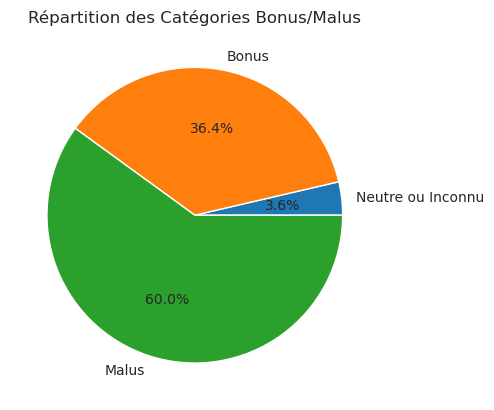

In [113]:
co2_df = final_catalogue_df_updated.withColumn("bonus_malus_category", 
    F.when(F.col("bonus_malus") > 0, "Bonus")
    .when(F.col("bonus_malus") < 0, "Malus")
    .otherwise("Neutre ou Inconnu"))

co2_df.groupBy("bonus_malus_category").count().show()

# Visualisation
bonus_dist = co2_df.groupBy("bonus_malus_category").count().toPandas()
plt.pie(bonus_dist["count"], labels=bonus_dist["bonus_malus_category"], autopct="%1.1f%%")
plt.title("Répartition des Catégories Bonus/Malus")
plt.show()


# **Analyse des Marques**

In [114]:
final_catalogue_df_updated.groupBy("marque").agg(F.avg("unified_horse_power").alias("avg_hp")).orderBy(F.desc("avg_hp")).show(10)


+--------+------------------+
|  marque|            avg_hp|
+--------+------------------+
|     bmw|             328.5|
|   volvo|             272.0|
|mercedes|             221.0|
|  jaguar|             197.0|
|   skoda|             193.0|
| renault|            178.75|
|    saab|             150.0|
|    fiat|             147.0|
|  nissan|141.33333333333334|
|    ford|             125.0|
+--------+------------------+


# **Valeurs aberrantes**

In [115]:
from pyspark.sql.functions import mean, stddev

stats = final_catalogue_df_updated.select(mean("unified_horse_power").alias("mean"), stddev("unified_horse_power").alias("stddev")).first()
mean_hp, stddev_hp = stats["mean"], stats["stddev"]

outliers = final_catalogue_df_updated.filter(
    (F.col("unified_horse_power") > mean_hp + 3 * stddev_hp) |
    (F.col("unified_horse_power") < mean_hp - 3 * stddev_hp)
)
print(f"Nombre de valeurs aberrantes : {outliers.count()}")
outliers.select("marque", "modele", "unified_horse_power", "prix").show()


Nombre de valeurs aberrantes : 10
+------+------+-------------------+-------+
|marque|modele|unified_horse_power|   prix|
+------+------+-------------------+-------+
|   bmw|    m5|              507.0|66360.0|
|   bmw|    m5|              507.0|94800.0|
|   bmw|    m5|              507.0|66360.0|
|   bmw|    m5|              507.0|66360.0|
|   bmw|    m5|              507.0|94800.0|
|   bmw|    m5|              507.0|66360.0|
|   bmw|    m5|              507.0|94800.0|
|   bmw|    m5|              507.0|94800.0|
|   bmw|    m5|              507.0|66360.0|
|   bmw|    m5|              507.0|94800.0|
+------+------+-------------------+-------+


Parmi les valeurs aberrantes, on observe des véhicules comme la BMW M5, qui combine une puissance très élevée (507 ch) avec des prix particulièrement élevés (>60 000 €). Ces valeurs reflètent des modèles de luxe ou de performance qui se situent bien au-delà de la moyenne des données.

# **Enregistrer les Données Fusionnées**

In [116]:
# # Enregistrer les données dans Hive
final_catalogue_df_updated.write.mode("overwrite").saveAsTable("catalogue_co2_merge_processed")
print("Données fusionnées enregistrées avec succès.")

Données fusionnées enregistrées avec succès.


# **Fermer la session Spark**

In [117]:
# Arrêter la session Spark
spark.stop()